# Introduction

The primary objective of this task is to build time series regression models to predict real estate sales in Turkey. To achieve that, various regression models will be developed, and both trend/seasonality variables will be incorporated along with the external factors such as economic indicators and search trends to improve the predictive accuracy of our models. <br/><br/>

We will use the public data provided by the Central Bank of the Republic of Turkey (CBRT) for economic indicators and Google Trends for the search trends data.
<br/><br/>
## Data Description

The dataset used in this study comprises monthly data from 2013-2024 on housing sales (konut_satis) along with several independent variables including trends in the number of houses for sale (satilik_ev_trend), housing price indices (konut_fiyat_endeksi), and unemployment rates (issizlik_orani). Additionally, the search trend data from Google Trends for relevant keywords is also incorporated into the model.
<br/><br/>
## Methods
Various time series regression analysis to model the relationship between housing sales and the independent variables will be developed. Relevant seasonal and trend data will be incorporated into the model and their effects will be analyzed through residual analysis, significance of coefficients and visualizations.
<br/><br/>
### Research Question
The primary research question addressed in this study is: How can real estate price indices, real estate sales, and unemployment rates in Turkey be effectively predicted using a combination of seasonality, trend (time), and Google Trends data? By exploring the relationship between these economic indicators and various external factors such as search trends and housing market trends, robust time series regression models are aimed to be developed that accurately forecast changes in the real estate market. Through comprehensive analysis of the significance of coefficients, residual diagnostics, and visualizations, efforts are made to identify the key drivers influencing housing market dynamics and provide insights for stakeholders in the real estate sector. Ultimately, the research aims to contribute to a better understanding of the factors driving fluctuations in the real estate market and inform decision-making processes.

# 1. Reading the data

In this part the data is read from the csv file and the numerical values are converted into a suitable format.

In [169]:
# importing external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.image as mpimg


df = pd.read_csv("EVDS.csv", sep=";")
df.dropna(inplace=True)

# Preprocessing the data: converting to numeric after removing commas and replacing '.' with ','
for col in df.columns:
    if col != 'tarih':
        df[col] = pd.to_numeric(df[col].str.replace('.', '').str.replace(',', '.'))
# display the dataframe
df

,tarih,konut_satis,USD_TRY,total_kredi,gercek_kira,konut_fiyat_endeksi,konut_faiz,issizlik_orani
0,2013-01,87444.0,1.78,7.623551e+08,297.54,56.9,9.78,10.1
1,2013-02,88519.0,1.81,7.755455e+08,298.62,57.6,9.58,10.1
2,2013-03,97956.0,1.80,8.020554e+08,299.99,58.4,9.31,10.1
3,2013-04,95381.0,1.83,8.156762e+08,301.50,59.2,9.06,10.1
4,2013-05,103261.0,1.90,8.611745e+08,302.87,60.0,8.77,10.1
...,...,...,...,...,...,...,...,...
128,2023-09,102656.0,27.90,1.025829e+10,1651.08,1087.9,40.25,8.9
129,2023-10,93761.0,28.67,1.047935e+10,1781.61,1129.5,41.53,8.2
130,2023-11,93514.0,29.10,1.078661e+10,1888.02,1150.0,42.15,8.8
131,2023-12,138577.0,30.08,1.118948e+10,1972.63,1163.3,42.09,8.9


# 2. Correlation Matrix

The series we have should not have an absolute correlation coefficient between each pair that is more than 0.5. Therefore, we compute the correlation matrix between the pairs, and eliminate the highly correlated pairs.

In [170]:
# Calculate correlation matrix
# Exclude 'tarih' column before calculating correlation matrix
correlation_matrix = df.drop('tarih', axis=1).corr().abs()

correlation_matrix

,konut_satis,USD_TRY,total_kredi,gercek_kira,konut_fiyat_endeksi,konut_faiz,issizlik_orani
konut_satis,1.000000,0.087007,0.081935,0.025462,0.004089,0.051017,0.112483
USD_TRY,0.087007,1.000000,0.994767,0.955319,0.968951,0.790332,0.225975
total_kredi,0.081935,0.994767,1.000000,0.964027,0.972239,0.791616,0.205690
gercek_kira,0.025462,0.955319,0.964027,1.000000,0.969131,0.847663,0.224603
konut_fiyat_endeksi,0.004089,0.968951,0.972239,0.969131,1.000000,0.786311,0.345291
konut_faiz,0.051017,0.790332,0.791616,0.847663,0.786311,1.000000,0.115595
issizlik_orani,0.112483,0.225975,0.205690,0.224603,0.345291,0.115595,1.000000


### Conclusion of the correlation matrix

The variables USD / TRY, total_kredi, gercek_kira, konut_fiyat_endeksi, and konut_faiz exhibit strong correlations, suggesting a coherence in their respective metrics.


Therefore, I will continue with only one of them, konut_fiyat_endeksi, since it directly reflects the price of the real estates.

In [171]:
# dropping the correlated features
df.drop(columns=["USD_TRY", "total_kredi", "gercek_kira", "konut_faiz"], inplace=True)
# calculating the correlation matrix again
correlation_matrix = df.drop('tarih', axis=1).corr().abs()
correlation_matrix

,konut_satis,konut_fiyat_endeksi,issizlik_orani
konut_satis,1.000000,0.004089,0.112483
konut_fiyat_endeksi,0.004089,1.000000,0.345291
issizlik_orani,0.112483,0.345291,1.000000


As can be seen there is no more correlated time series in the data.

# 3. Integrating Google Trends Data

In this section relevant google trends data is read and preprocessed. Below are the search keywords that are used:

| Time Serie   |      Search Keyword     
|----------|:-------------:|
| Real Estate Sales |  Satılık Ev |
| Real Estate Price Index |    Ev fiyat   |
| Unemployment Rate | İşsizlik |


In [172]:
# read the data
df_ev_fiyat_trend = pd.read_csv("google_trends_data/ev_fiyatlari.csv", skiprows=1)
df_satilik_ev_trend = pd.read_csv("google_trends_data/satilik_ev.csv", skiprows=1)
df_is_ilani_trend = pd.read_csv("google_trends_data/is_ilan.csv", skiprows=1)

# filter by dates
df_ev_fiyat_trend = df_ev_fiyat_trend[(df_ev_fiyat_trend["Month"] >= "2013-01") & (df_ev_fiyat_trend["Month"] <= "2024-01") ]
df_satilik_ev_trend = df_satilik_ev_trend[(df_satilik_ev_trend["Month"] >= "2013-01") & (df_satilik_ev_trend["Month"] <= "2024-01") ]
df_is_ilani_trend = df_is_ilani_trend[(df_is_ilani_trend["Month"] >= "2013-01") & (df_is_ilani_trend["Month"] <= "2024-01")]

# 4. Exploratory Data Analysis

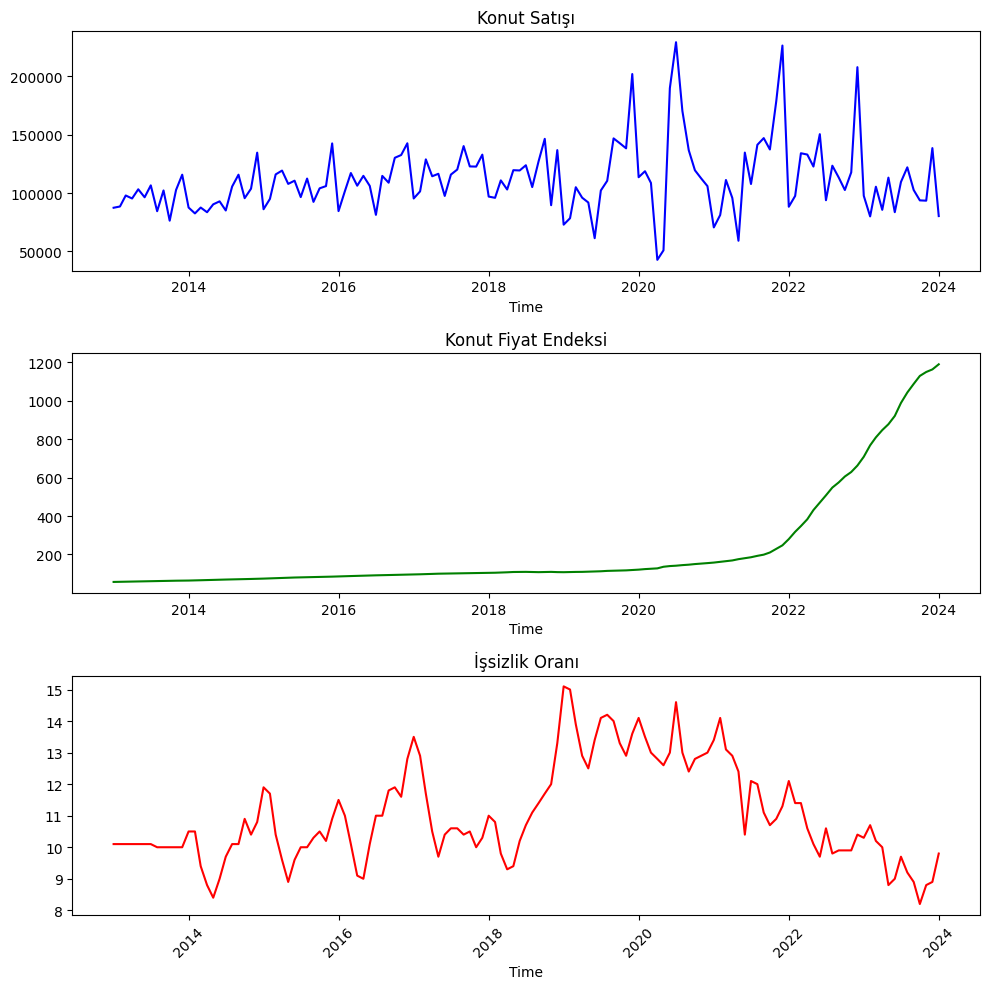

In [173]:
# Convert string dates to datetime objects
x = df_satilik_ev_trend.iloc[:, 0].values
x_datetime = [datetime.strptime(date, '%Y-%m') for date in x]

# Extract columns from the original DataFrame
konut_satis = df['konut_satis']
konut_fiyat_endeksi = df['konut_fiyat_endeksi']
issizlik_orani = df['issizlik_orani']

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Plot konut_satis
axs[0].plot(x_datetime, konut_satis, color='blue')
axs[0].set_title('Konut Satışı')

# Plot konut_fiyat_endeksi
axs[1].plot(x_datetime, konut_fiyat_endeksi, color='green')
axs[1].set_title('Konut Fiyat Endeksi')

# Plot issizlik_orani
axs[2].plot(x_datetime, issizlik_orani, color='red')
axs[2].set_title('İşsizlik Oranı')

# Set common x-axis label
for ax in axs:
    ax.set_xlabel('Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

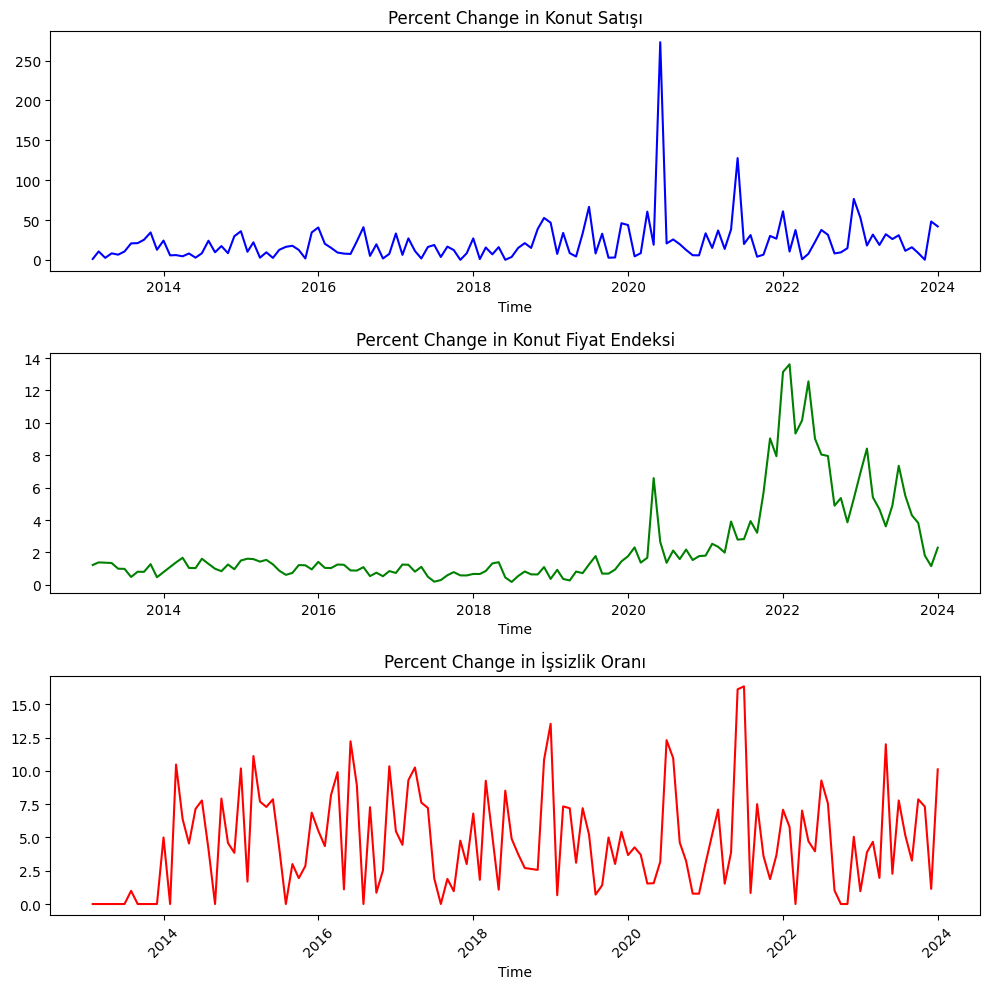

In [174]:
# Convert string dates to datetime objects
x = df_satilik_ev_trend.iloc[:, 0].values
x_datetime = [datetime.strptime(date, '%Y-%m') for date in x]

# Calculate the percent change for each variable
konut_satis_change = (df['konut_satis'].diff() / df['konut_satis'].shift(1)).abs() * 100
konut_fiyat_endeksi_change = (df['konut_fiyat_endeksi'].diff() / df['konut_fiyat_endeksi'].shift(1)).abs() * 100
issizlik_orani_change = (df['issizlik_orani'].diff() / df['issizlik_orani'].shift(1)).abs() * 100

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Plot percent change of konut_satis
axs[0].plot(x_datetime[1:], konut_satis_change[1:], color='blue')
axs[0].set_title('Percent Change in Konut Satışı')

# Plot percent change of konut_fiyat_endeksi
axs[1].plot(x_datetime[1:], konut_fiyat_endeksi_change[1:], color='green')
axs[1].set_title('Percent Change in Konut Fiyat Endeksi')

# Plot percent change of issizlik_orani
axs[2].plot(x_datetime[1:], issizlik_orani_change[1:], color='red')
axs[2].set_title('Percent Change in İşsizlik Oranı')

# Set common x-axis label
for ax in axs:
    ax.set_xlabel('Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Real Estate Sales

Let's visualize Real Estate Sales and and Google Trends data for "Satılık Ev".

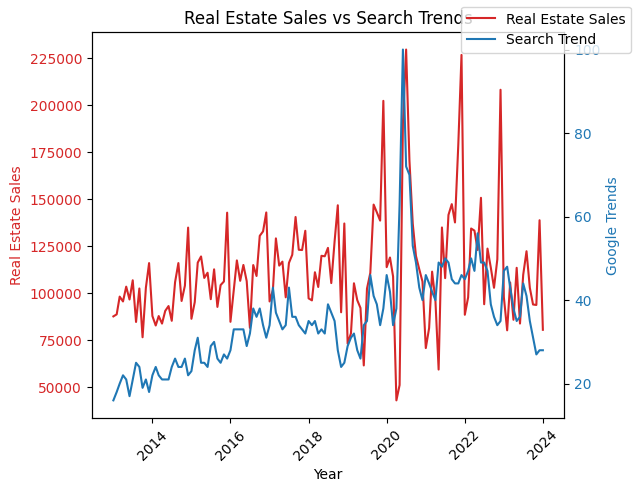

Correlation between Real Estate Sales and Google Trends: 0.4056492699274645


In [175]:
y1 = df['konut_satis'].values
y2 = df_satilik_ev_trend.iloc[:, 1].replace('<1', "1").astype(float).values
x = df_satilik_ev_trend.iloc[:, 0].values

# Convert string dates to datetime objects
x_datetime = [datetime.strptime(date, '%Y-%m') for date in x]

# Plotting the data for y1
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Real Estate Sales', color=color)
ax1.plot(x_datetime, y1, color=color, label='Real Estate Sales')
ax1.tick_params(axis='y', labelcolor=color)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Plotting the data for y2 (Google Trends) on secondary y-axis
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Google Trends', color=color)
ax2.plot(x_datetime, y2, color=color, label='Search Trend')
ax2.tick_params(axis='y', labelcolor=color)

# Adding legend
fig.legend(loc="upper right")

plt.tight_layout()
plt.title("Real Estate Sales vs Search Trends")
plt.show()

correlation = np.corrcoef(y1, y2)[0, 1]

print("Correlation between Real Estate Sales and Google Trends:", correlation)


Another way that can be used for visualization is to visualize the percent change in the real estate sales with the search data since changes can also be a good indicator of popularity.

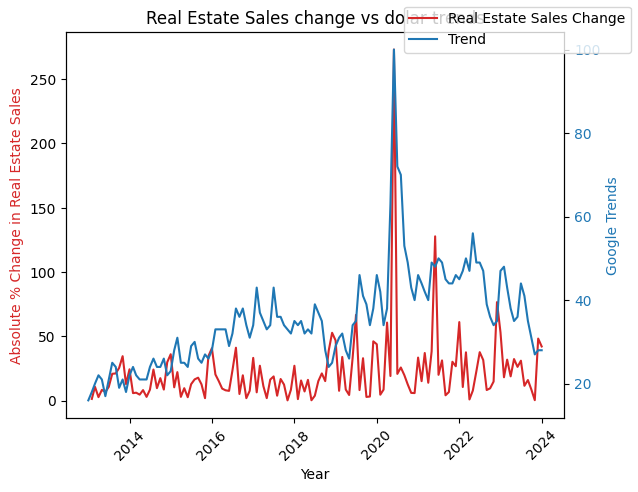

Correlation between Real Estate Sales Change and Google Trends: 0.4912722828132345


In [176]:
y1 = df['konut_satis']
y1_change = (y1.diff() / y1.shift(1)).abs() * 100  # Calculate absolute percent change

y2 = df_satilik_ev_trend.iloc[:, 1].replace('<1', "1").astype(float).values
x = df_satilik_ev_trend.iloc[:, 0].values

# Convert string dates to datetime objects
x_datetime = [datetime.strptime(date, '%Y-%m') for date in x]

# Plotting the data for y1
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Absolute % Change in Real Estate Sales', color=color)
ax1.plot(x_datetime[1:], y1_change[1:], color=color, label='Real Estate Sales Change')  # Omitting the first value

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Plotting the data for y2 (Google Trends) on secondary y-axis
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Google Trends', color=color)
ax2.plot(x_datetime, y2, color=color, label='Trend')
ax2.tick_params(axis='y', labelcolor=color)

# Adding legend
fig.legend(loc="upper right")

plt.tight_layout()
plt.title("Real Estate Sales change vs dolar trends")
plt.show()

correlation = np.corrcoef(y1_change[1:], y2[1:])[0, 1]

print("Correlation between Real Estate Sales Change and Google Trends:", correlation)

**Conclusion:** As can be seen from the above graphs, there is 0.4 and 0.5 correlation between Real Estate Sales vs. Google Trends and Real Estate Sales Change vs. Google Trends, respectively, suggesting that the data pair is correlated. This conclusion is also obvious in the visualizations.

## Real Estate Price Index

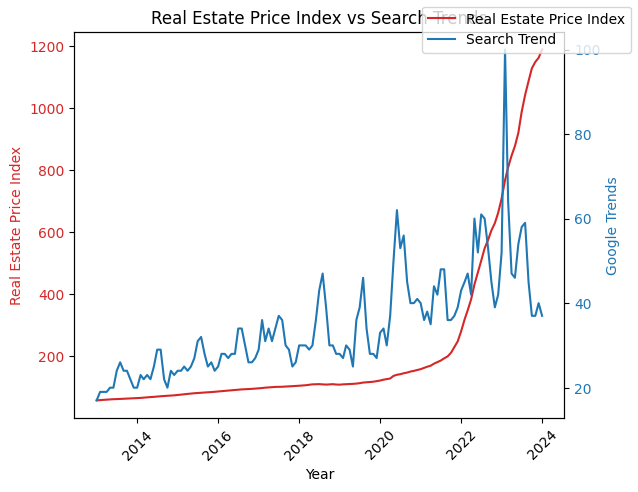

Correlation between Real Estate Price Index and Google Trends: 0.5858859824518642


In [177]:
y1 = df['konut_fiyat_endeksi'].values
y2 = df_ev_fiyat_trend.iloc[:, 1].replace('<1', "1").astype(float).values
x = df_ev_fiyat_trend.iloc[:, 0].values

# Convert string dates to datetime objects
x_datetime = [datetime.strptime(date, '%Y-%m') for date in x]

# Plotting the data for y1
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Real Estate Price Index', color=color)
ax1.plot(x_datetime, y1, color=color, label='Real Estate Price Index')
ax1.tick_params(axis='y', labelcolor=color)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Plotting the data for y2 (Google Trends) on secondary y-axis
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Google Trends', color=color)
ax2.plot(x_datetime, y2, color=color, label='Search Trend')
ax2.tick_params(axis='y', labelcolor=color)

# Adding legend
fig.legend(loc="upper right")

plt.tight_layout()
plt.title("Real Estate Price Index vs Search Trends")
plt.show()

correlation = np.corrcoef(y1, y2)[0, 1]

print("Correlation between Real Estate Price Index and Google Trends:", correlation)

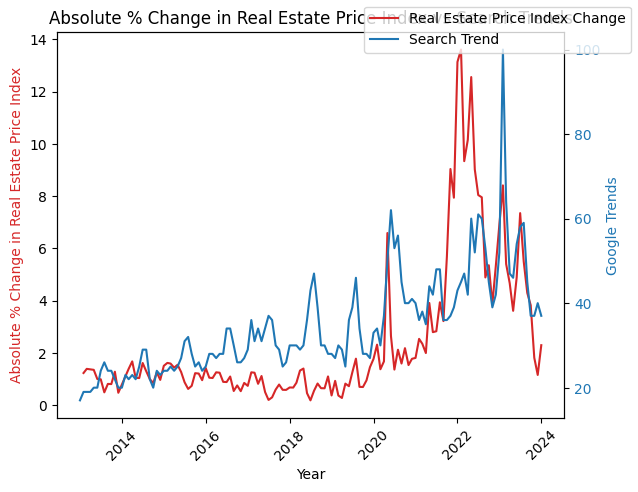

Correlation between Real Estate Price Index and Google Trends: 0.6375521089402919


In [178]:
y1 = df['konut_fiyat_endeksi']
y1_change = (y1.diff() / y1.shift(1)).abs() * 100

y2 = df_ev_fiyat_trend.iloc[:, 1].replace('<1', "1").astype(float).values
x = df_ev_fiyat_trend.iloc[:, 0].values

# Convert string dates to datetime objects
x_datetime = [datetime.strptime(date, '%Y-%m') for date in x]

# Plotting the data
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Absolute % Change in Real Estate Price Index', color=color)
ax1.plot(x_datetime[1:], y1_change[1:], color=color, label='Real Estate Price Index Change')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Plotting the data for y2 (Google Trends) on secondary y-axis
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Google Trends', color=color)
ax2.plot(x_datetime, y2, color=color, label='Search Trend')
ax2.tick_params(axis='y', labelcolor=color)

# Adding legend
fig.legend(loc="upper right")

plt.tight_layout()
plt.title("Absolute % Change in Real Estate Price Index vs Search Trends")
plt.show()

correlation = np.corrcoef(y1_change[1:], y2[1:])[0, 1]

print("Correlation between Real Estate Price Index and Google Trends:", correlation)

**Conclusion:** As can be seen from the above graphs, there is 0.59 and 0.64 correlation between Real Estate Price Index vs. Google Trends and Real Estate Price Index Change vs. Google Trends, respectively, suggesting that the data pair is correlated. This conclusion is also obvious from the visualizations.

## Unemployment Rate

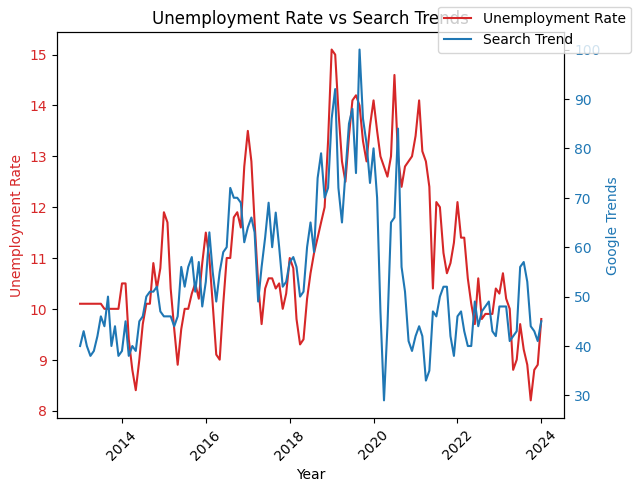

Correlation between Unemployment and Google Trends: 0.5537799287656614


In [179]:
y1 = df['issizlik_orani'].values
y2 = df_is_ilani_trend.iloc[:, 1].replace('<1', "1").astype(float).values
x = df_is_ilani_trend.iloc[:, 0].values

# Convert string dates to datetime objects
x_datetime = [datetime.strptime(date, '%Y-%m') for date in x]

# Plotting the data for y1
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Unemployment Rate', color=color)
ax1.plot(x_datetime, y1, color=color, label='Unemployment Rate')
ax1.tick_params(axis='y', labelcolor=color)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Plotting the data for y2 (Google Trends) on secondary y-axis
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Google Trends', color=color)
ax2.plot(x_datetime, y2, color=color, label='Search Trend')
ax2.tick_params(axis='y', labelcolor=color)

# Adding legend
fig.legend(loc="upper right")

plt.tight_layout()
plt.title("Unemployment Rate vs Search Trends")
plt.show()

correlation = np.corrcoef(y1, y2)[0, 1]

print("Correlation between Unemployment and Google Trends:", correlation)

**Conclusion:** Again, there is a good amount (0.55) correlation between the Unemployment Rate and the search keyword "İş İlanı".

# 5. Time Series Regression - Real Estate Sales

### 5.1 Using Real Estate Price Index and basic time trend to predict Real Estate Sales

In [180]:
y = df['konut_satis'].values.reshape(-1, 1)
x = df['konut_fiyat_endeksi'].values.reshape(-1, 1)
t = np.arange(1, len(x)+1).reshape(-1, 1)

# Concatenate t and x to create feature matrix X
X = np.concatenate((t, x), axis=1)

# Add a constant term to the feature matrix X
X = sm.add_constant(X)

# Create a linear regression model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     7.439
Date:                Fri, 05 Apr 2024   Prob (F-statistic):           0.000873
Time:                        18:14:57   Log-Likelihood:                -1550.7
No. Observations:                 133   AIC:                             3107.
Df Residuals:                     130   BIC:                             3116.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        9.58e+04   5192.157     18.450      0.0

#### Evaluation:
The OLS regression results reveal that the model explains around 10.3% of the variance in the dependent variable, with an adjusted R-squared value of 8.9%. The F-statistic is significant (p = 0.000873), indicating that the overall regression model is statistically significant. Analyzing the coefficients, we find that konut_fiyat_endeksi positively influences the dependent variable, while the time trend exhibits a negative effect. Both coefficients are statistically significant (p < 0.05). The diagnostic statistics suggest some limitations in the model's goodness of fit and the presence of autocorrelation. While statistically significant, the model's explanatory power remains modest, underscoring the potential for further refinement or the inclusion of additional predictors to enhance predictive accuracy.





### 5.2 Using Unemployment Rate and basic time trend to predict Real Estate Sales

In [181]:
y = df['konut_satis'].values.reshape(-1, 1)
x = df['issizlik_orani'].values.reshape(-1, 1)
t = np.arange(1, len(x)+1).reshape(-1, 1)

# Concatenate t and x to create feature matrix X
X = np.concatenate((t, x), axis=1)

# Add a constant term to the feature matrix X
X = sm.add_constant(X)

# Create a linear regression model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.853
Date:                Fri, 05 Apr 2024   Prob (F-statistic):             0.0237
Time:                        18:14:57   Log-Likelihood:                -1554.0
No. Observations:                 133   AIC:                             3114.
Df Residuals:                     130   BIC:                             3123.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.556e+04   1.81e+04      4.734      0.0

#### Evaluation:

The OLS regression results indicate that the model explains approximately 5.6% of the variance in the dependent variable, with an adjusted R-squared value of 4.1%. The F-statistic is statistically significant (p = 0.0237), suggesting that the overall regression model has explanatory power. Analyzing the coefficients, we find that the intercept (const) is estimated to be 8.556e+04, representing the expected value of the dependent variable when all predictors are zero. The coefficient for x1 (unemployment rate) is 163.1207, indicating that for each unit increase in the unemployment rate, the dependent variable is expected to increase by approximately 163.12 units. However, the coefficient for x2 (time trend) is not statistically significant (p = 0.401), suggesting that the time trend does not have a significant effect on the dependent variable in this model. Diagnostic statistics indicate some limitations in the model's goodness of fit, the presence of autocorrelation, and departure from normality in residuals. Further refinement or inclusion of additional predictors may be necessary to improve the model's predictive accuracy.

### 5.3 Using Google Trends data for "Satılık Ev" and basic time trend to predict Real Estate Sales

In [182]:
y = df['konut_satis'].values.reshape(-1, 1)
x = df_satilik_ev_trend.iloc[:, 1].replace('<1', "1").astype(float).values.reshape(-1, 1)
t = np.arange(1, len(x)+1).reshape(-1, 1)

# Concatenate t and x to create feature matrix X
X = np.concatenate((t, x), axis=1)

# Add a constant term to the feature matrix X
X = sm.add_constant(X)

# Create a linear regression model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     12.97
Date:                Fri, 05 Apr 2024   Prob (F-statistic):           7.30e-06
Time:                        18:14:57   Log-Likelihood:                -1545.8
No. Observations:                 133   AIC:                             3098.
Df Residuals:                     130   BIC:                             3106.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.576e+04   7467.139     10.145      0.0

#### Evaluation:

The OLS regression results show that the model explains approximately 16.6% of the variance in the dependent variable, with an adjusted R-squared value of 15.4%. The F-statistic is highly significant (p < 0.0001), indicating that the overall regression model has strong explanatory power. Analyzing the coefficients, the intercept (const) is estimated to be 7.576e+04, representing the expected value of the dependent variable when all predictors are zero. The coefficient for x1 (Google search trends for "Satılık Ev") is -42.5240, but it is not statistically significant (p = 0.596), suggesting that the Google search trends for "Satılık Ev" do not have a significant effect on the dependent variable in this model. However, the coefficient for x2 (time trend) is statistically significant (p < 0.0001), indicating that there is a significant positive relationship between time trend and the dependent variable. Diagnostic statistics suggest some limitations in the model's goodness of fit, with skewness in residuals and departure from normality. Further exploration or inclusion of additional predictors may be necessary to enhance the model's predictive accuracy.

### 5.4 Trying all the features together to see if the model improves

In [183]:
y = df['konut_satis'].values.reshape(-1, 1)
x1 = df_satilik_ev_trend.iloc[:, 1].replace('<1', "1").astype(float).values.reshape(-1, 1)
x2 = df['konut_fiyat_endeksi'].values.reshape(-1, 1)
x3 = df['issizlik_orani'].values.reshape(-1, 1)

# Generate time series data
t = np.arange(1, len(x1) + 1).reshape(-1, 1)

# Concatenate t, x1, x2, and x3 to create feature matrix X
X = np.concatenate((t, x1, x2, x3), axis=1)

# Add a constant term to the feature matrix X
X = sm.add_constant(X)

# Create a linear regression model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     7.315
Date:                Fri, 05 Apr 2024   Prob (F-statistic):           2.45e-05
Time:                        18:14:57   Log-Likelihood:                -1544.2
No. Observations:                 133   AIC:                             3098.
Df Residuals:                     128   BIC:                             3113.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.108e+05   2.26e+04      4.911      0.0

#### Evaluation:

The OLS regression results reveal that the model explains approximately 18.6% of the variance in the dependent variable, with an adjusted R-squared value of 16.1%. The F-statistic is statistically significant (p < 0.0001), indicating that the overall regression model has explanatory power.

Analyzing the coefficients, the intercept (const) is estimated to be 1.108e+05, representing the expected value of the dependent variable when all predictors are zero. Among the predictors, only x2 (time trend) exhibits a statistically significant positive effect on the dependent variable (p = 0.001). However, the coefficients for x1 (Google search trends for "Satılık Ev"), x3 (konut_fiyat_endeksi), and x4 (unemployment rate) are not statistically significant at conventional levels (p > 0.05).

Diagnostic statistics suggest some limitations in the model's goodness of fit, with skewness in residuals and departure from normality. Additionally, the large condition number (3.5e+03) indicates potential multicollinearity or other numerical problems in the model.

Overall, while the model shows some explanatory power, the statistical significance and contribution of individual predictors are mixed. Further investigation into the model's assumptions and potential refinement of predictors may be necessary to enhance its predictive accuracy.

### Visualizing the results so far

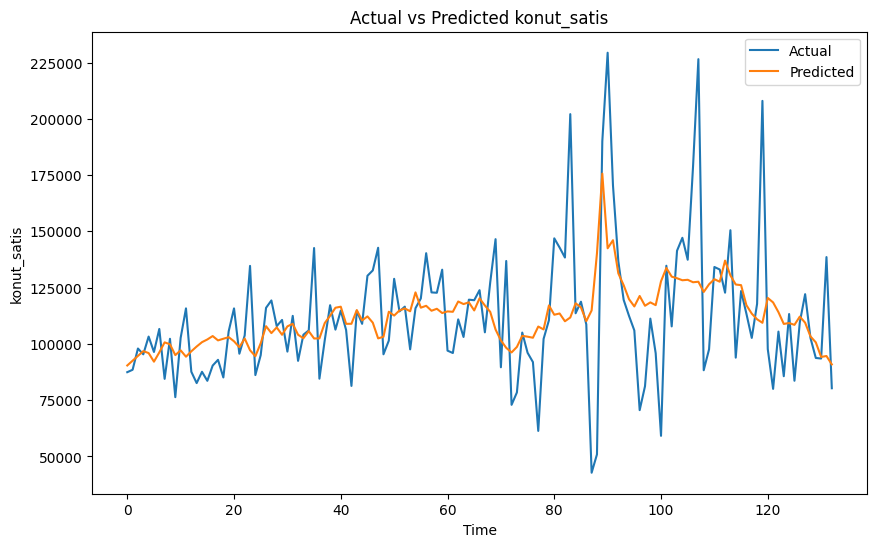

In [184]:
# Get predictions
predictions = results.predict(X)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('konut_satis')
plt.title('Actual vs Predicted konut_satis')
plt.legend()
plt.show()

### Residuals

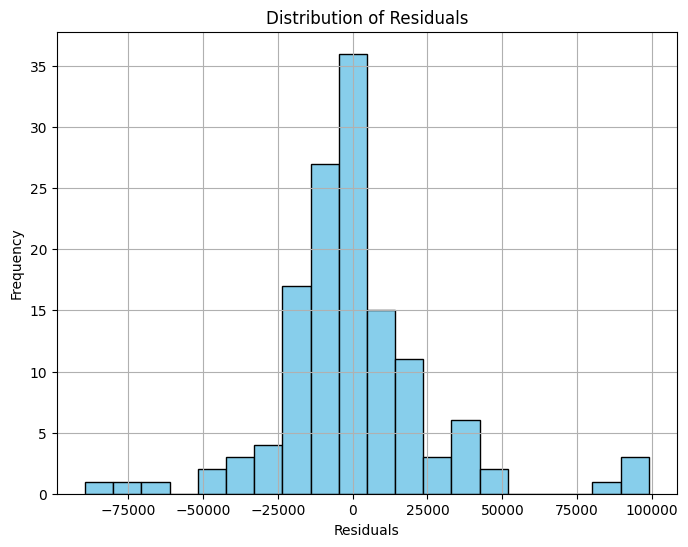

In [185]:
# Get the residuals from the model
residuals = results.resid

# Plot a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Evaluation:

Residuals do not violate the assumption of normality.

### 5.5 Adding 11 new binary variables indicating the month to capture *seasonality*

In [186]:
# Extract 'konut_satis' and other independent variables
y = df['konut_satis'].values
x1 = df_satilik_ev_trend.iloc[:, 1].replace('<1', "1").astype(float).values
x2 = df['konut_fiyat_endeksi'].values
x3 = df['issizlik_orani'].values

# Extract month from 'tarih' column
months = pd.to_datetime(df['tarih']).dt.month.values

# Create binary features for months
binary_features = pd.get_dummies(months, prefix='M').iloc[:, :-1].values

# Generate time series data for the difference
t = np.arange(1, len(y) + 1)

# Concatenate t, binary_features, x1, x2, and x3 to create feature matrix X
X = np.concatenate((t.reshape(-1, 1), binary_features, x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1)), axis=1)

# Add a constant term to the feature matrix X
X = sm.add_constant(X)

# Create a linear regression model for the difference
model = sm.OLS(y, X)

# Fit the model for the difference
results = model.fit()

# Print the summary for the difference model
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     8.870
Date:                Fri, 05 Apr 2024   Prob (F-statistic):           2.26e-13
Time:                        18:14:58   Log-Likelihood:                -1507.4
No. Observations:                 133   AIC:                             3047.
Df Residuals:                     117   BIC:                             3093.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.596e+05   2.17e+04      7.342      0.0

#### Evaluation:

The updated OLS regression results indicate a substantial improvement in the model's explanatory power, with an R-squared value of 53.2% and an adjusted R-squared value of 47.2%. The F-statistic remains statistically significant (p < 0.0001), suggesting that the overall regression model is significant.

Examining the coefficients, the intercept (const) is estimated to be 1.596e+05, representing the expected value of the dependent variable when all predictors are zero. Among the predictors, several binary features indicating the month of the year (x2 to x12) demonstrate statistically significant effects on the dependent variable, with negative coefficients ranging from approximately -4.128e+04 to -6.743e+04. This suggests that real estate sales tend to decrease during certain months compared to the reference month.

Additionally, x1 (google search trends for "satılık ev") and x14 (unemployment rate) do not exhibit statistically significant effects on the dependent variable, as their p-values are greater than 0.05. The other predictors are statistically significant at conventional levels.

Diagnostic statistics suggest that the model's residuals exhibit skewness and departure from normality, as indicated by the Omnibus test and the Jarque-Bera test. The Durbin-Watson statistic is close to 1.5, indicating no significant autocorrelation in the residuals.

Overall, the inclusion of binary features representing the month of the year significantly improves the model's explanatory power, providing valuable insights into the seasonality of real estate sales.

### Visualizing the Predictions

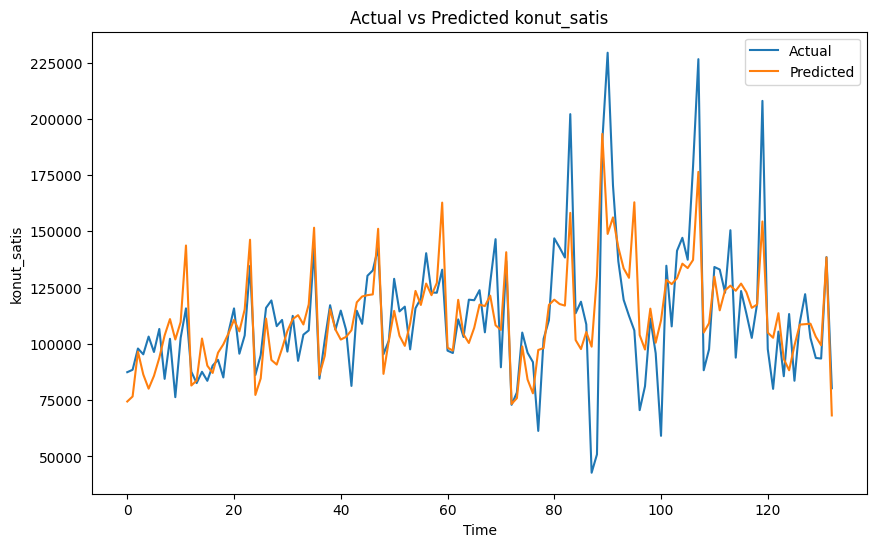

In [187]:
# Get predictions
predictions = results.predict(X)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('konut_satis')
plt.title('Actual vs Predicted konut_satis')
plt.legend()
plt.show()

### Residuals

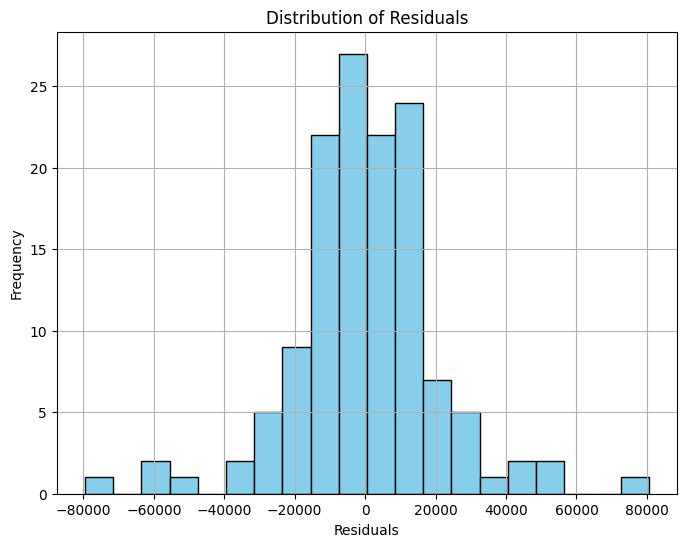

In [188]:
# Get the residuals from the model
residuals = results.resid

# Plot a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Evaluation:

Residuals do not violate the assumption of normality.

# 6. Time Series Regression - Real Estate Price Index

In [189]:
y = df['konut_fiyat_endeksi'].values
x1 = df_ev_fiyat_trend.iloc[:, 1].replace('<1', "1").astype(float).values
x2 = df['konut_satis'].values
x3 = df['issizlik_orani'].values

# Extract month from 'tarih' column
months = pd.to_datetime(df['tarih']).dt.month.values

# Create binary features for months
binary_features = pd.get_dummies(months, prefix='M').iloc[:, :-1].values

# Generate time series data for the difference
t = np.arange(1, len(y) + 1)

# Concatenate t, binary_features, x1, x2, and x3 to create feature matrix X
X = np.concatenate((t.reshape(-1, 1), binary_features, x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1)), axis=1)

# Add a constant term to the feature matrix X
X = sm.add_constant(X)

# Create a linear regression model for the difference
model = sm.OLS(y, X)

# Fit the model for the difference
results = model.fit()

# Print the summary for the difference model
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     33.98
Date:                Fri, 05 Apr 2024   Prob (F-statistic):           1.50e-35
Time:                        18:14:59   Log-Likelihood:                -825.85
No. Observations:                 133   AIC:                             1684.
Df Residuals:                     117   BIC:                             1730.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1165.7533    114.080     10.219      0.0

It seems like x13 (google trends data) introduces multicollinearity. Let's drop it and try again.

In [190]:
y = df['konut_fiyat_endeksi'].values
x2 = df['konut_satis'].values
x3 = df['issizlik_orani'].values

# Extract month from 'tarih' column
months = pd.to_datetime(df['tarih']).dt.month.values

# Create binary features for months
binary_features = pd.get_dummies(months, prefix='M').iloc[:, :-1].values

# Generate time series data for the difference
t = np.arange(1, len(y) + 1)

# Concatenate t, binary_features, x1, x2, and x3 to create feature matrix X
X = np.concatenate((t.reshape(-1, 1), binary_features, x2.reshape(-1, 1), x3.reshape(-1, 1)), axis=1)

# Add a constant term to the feature matrix X
X = sm.add_constant(X)

# Create a linear regression model for the difference
model = sm.OLS(y, X)

# Fit the model for the difference
results = model.fit()

# Print the summary for the difference model
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     36.70
Date:                Fri, 05 Apr 2024   Prob (F-statistic):           2.47e-36
Time:                        18:14:59   Log-Likelihood:                -825.88
No. Observations:                 133   AIC:                             1682.
Df Residuals:                     118   BIC:                             1725.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1172.5980    109.324     10.726      0.0

#### Evaluation:

The OLS regression results indicate a reasonably high R-squared value of 0.813, suggesting that approximately 81.3% of the variance in the dependent variable ('y') is explained by the independent variables in the model. The adjusted R-squared value, which accounts for the number of predictors in the model, is 0.789, indicating a good fit of the model.

### Visualization of Predictions

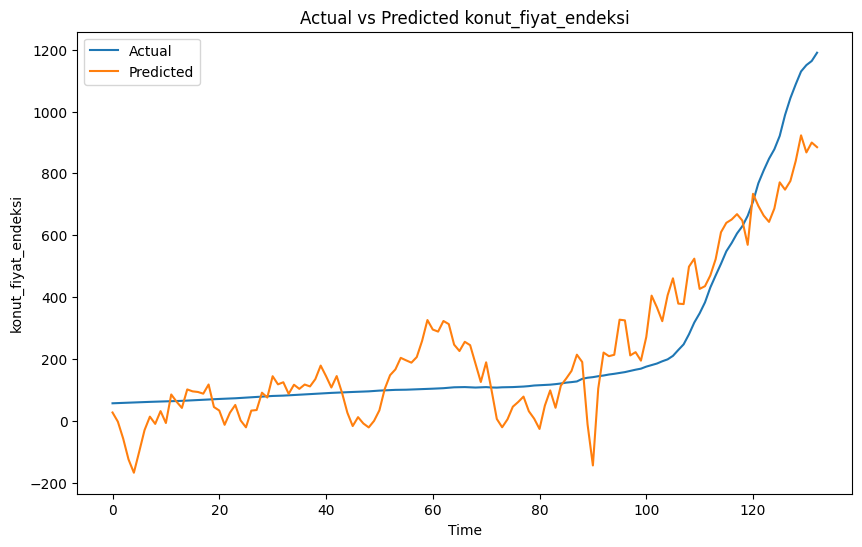

In [191]:
# Get predictions
predictions = results.predict(X)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('konut_fiyat_endeksi')
plt.title('Actual vs Predicted konut_fiyat_endeksi')
plt.legend()
plt.show()

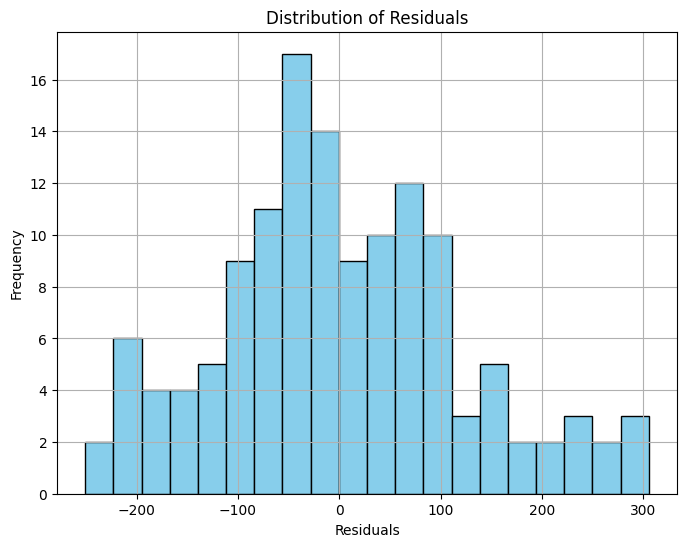

In [192]:
# Get the residuals from the model
residuals = results.resid

# Plot a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Evaluation:

Residuals do not violate the assumption of normality.

# 7. Time Series Regression - Unemployment Rate

### 7.1 Google Trends Data for "İş İlanı" vs Unemployment Rate

In [193]:
y = df['issizlik_orani'].values
x = df_is_ilani_trend.iloc[:, 1].replace('<1', "1").astype(float).values


# Add a constant term to the feature matrix X
X = sm.add_constant(x)

# Create a linear regression model for the difference
model = sm.OLS(y, x)

# Fit the model for the difference
results = model.fit()

# Print the summary for the difference model
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              3031.
Date:                Fri, 05 Apr 2024   Prob (F-statistic):                    6.35e-93
Time:                        18:15:00   Log-Likelihood:                         -298.47
No. Observations:                 133   AIC:                                      598.9
Df Residuals:                     132   BIC:                                      601.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

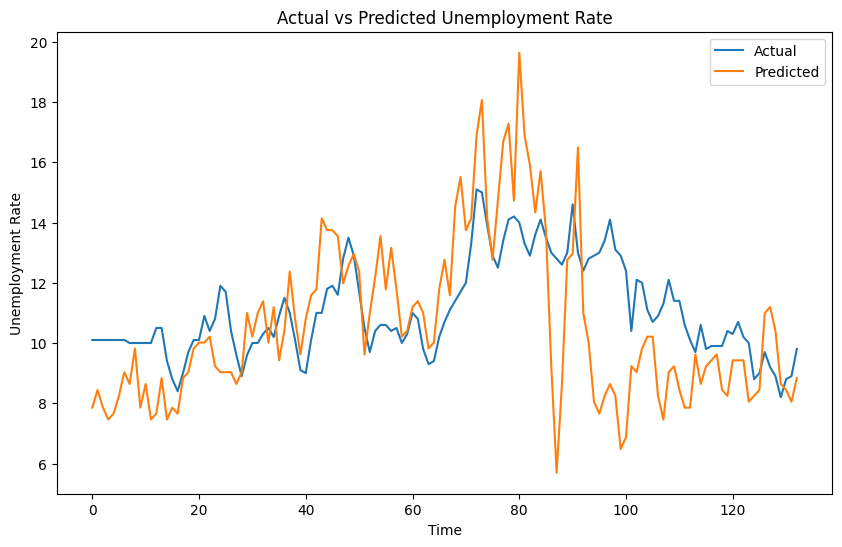

In [194]:
# Get predictions
predictions = results.predict(x)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Unemployment Rate')
plt.title('Actual vs Predicted Unemployment Rate')
plt.legend()
plt.show()

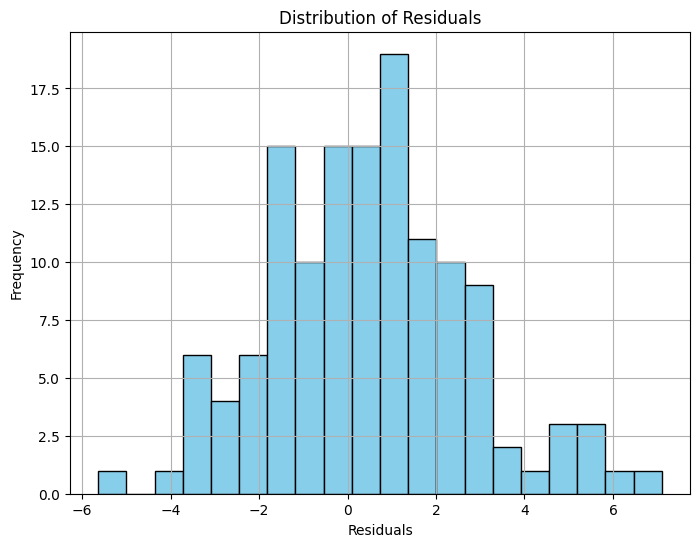

In [195]:
# Get the residuals from the model
residuals = results.resid

# Plot a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 7.2 Adding other features

In [196]:
y = df['issizlik_orani'].values
x1 = df_is_ilani_trend.iloc[:, 1].replace('<1', "1").astype(float).values
x2 = df['konut_satis'].values
x3 = df['konut_fiyat_endeksi'].values

# Extract month from 'tarih' column
months = pd.to_datetime(df['tarih']).dt.month.values

# Create binary features for months
binary_features = pd.get_dummies(months, prefix='M').iloc[:, :-1].values

# Generate time series data for the difference
t = np.arange(1, len(y) + 1)

# Concatenate t, binary_features, x1, x2, and x3 to create feature matrix X
X = np.concatenate((t.reshape(-1, 1), binary_features, x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1)), axis=1)

# Add a constant term to the feature matrix X
X = sm.add_constant(X)

# Create a linear regression model for the difference
model = sm.OLS(y, X)

# Fit the model for the difference
results = model.fit()

# Print the summary for the difference model
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     22.31
Date:                Fri, 05 Apr 2024   Prob (F-statistic):           1.75e-27
Time:                        18:15:01   Log-Likelihood:                -158.06
No. Observations:                 133   AIC:                             348.1
Df Residuals:                     117   BIC:                             394.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4500      0.582     16.241      0.0

### Evaluation:

We have an event lower Adj. R-squared value for this fit, it is better to just use the google trends data to predict unemployment.

# 8. Conclusion

Below are the summary of our results:

| Target   |      Best R-squared     |  Features |
|----------|:-------------:|------:|
| Real Estate Sales |  0.532 | Trend + Seasonality + Google Trends Data |
| Real Estate Price Index |    0.813   |   Trend + Seasonality + Google Trends Data |
| Unemployment Rate | 0.958 |    Google Trends Data |

In conclusion, this homework has investigated the predictive capabilities of time series regression models for real estate price indices, real estate sales, and unemployment rates in Turkey. By incorporating seasonality, trend (time), and Google Trends data, it is aimed to enhance the accuracy of our predictions and provide valuable insights into the dynamics of the real estate market.

The analysis revealed that the inclusion of external factors such as search trends and housing market trends significantly improved the predictive performance of the models. Through statistical analysis, key drivers influencing housing market fluctuations are determined.

However, it's important to note that while the models demonstrated high predictive accuracy, they are subject to certain limitations and assumptions. Factors such as economic volatility, unforeseen events, and changes in consumer behavior may impact the real estate market in ways that are difficult to predict solely based on historical data.







### Summary of the predictions

## Target: Real Estate Sales

R-squared: 0.532

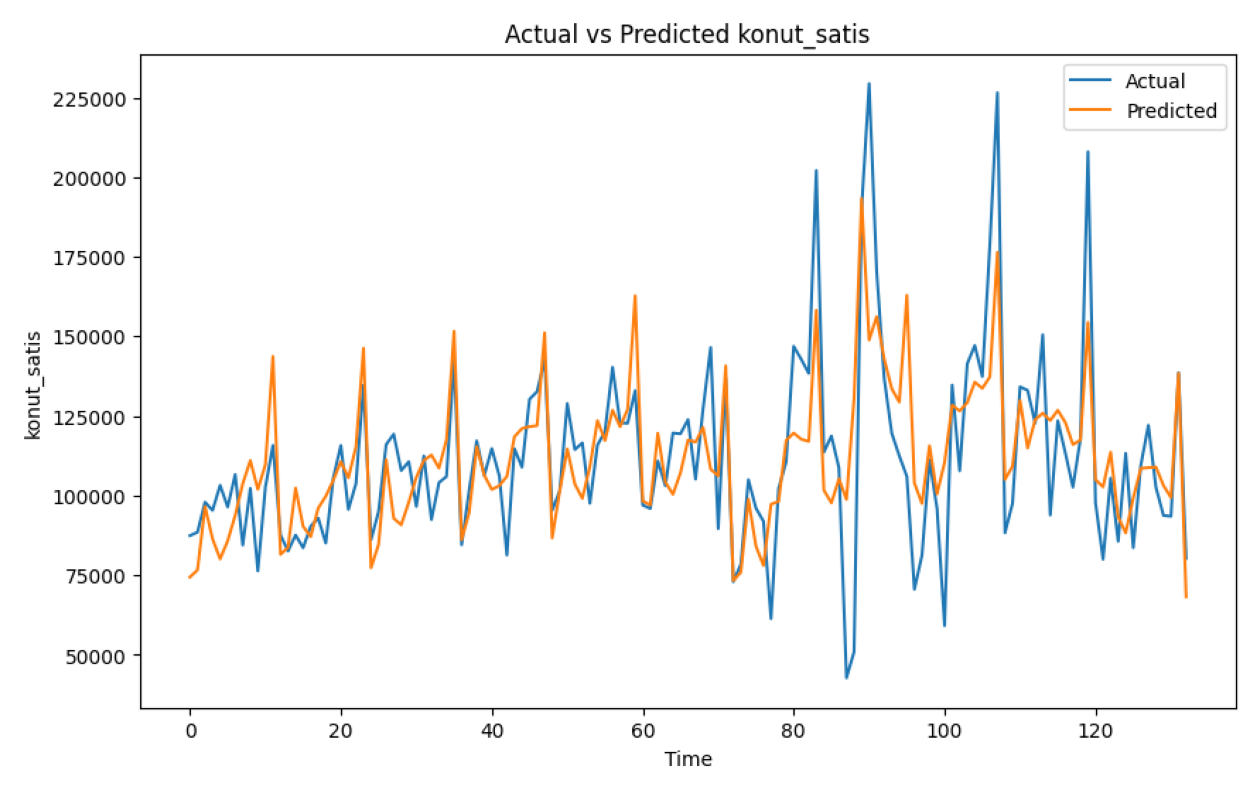

In [197]:
# Read the image
img = mpimg.imread("/content/satış.png")

# Create a larger figure
plt.figure(figsize=(16, 13))

# Display the image
plt.imshow(img)

# Turn off axis
plt.axis("off")

# Show the image
plt.show()

## Target: Real Estate Price Index

R-squared: 0.813

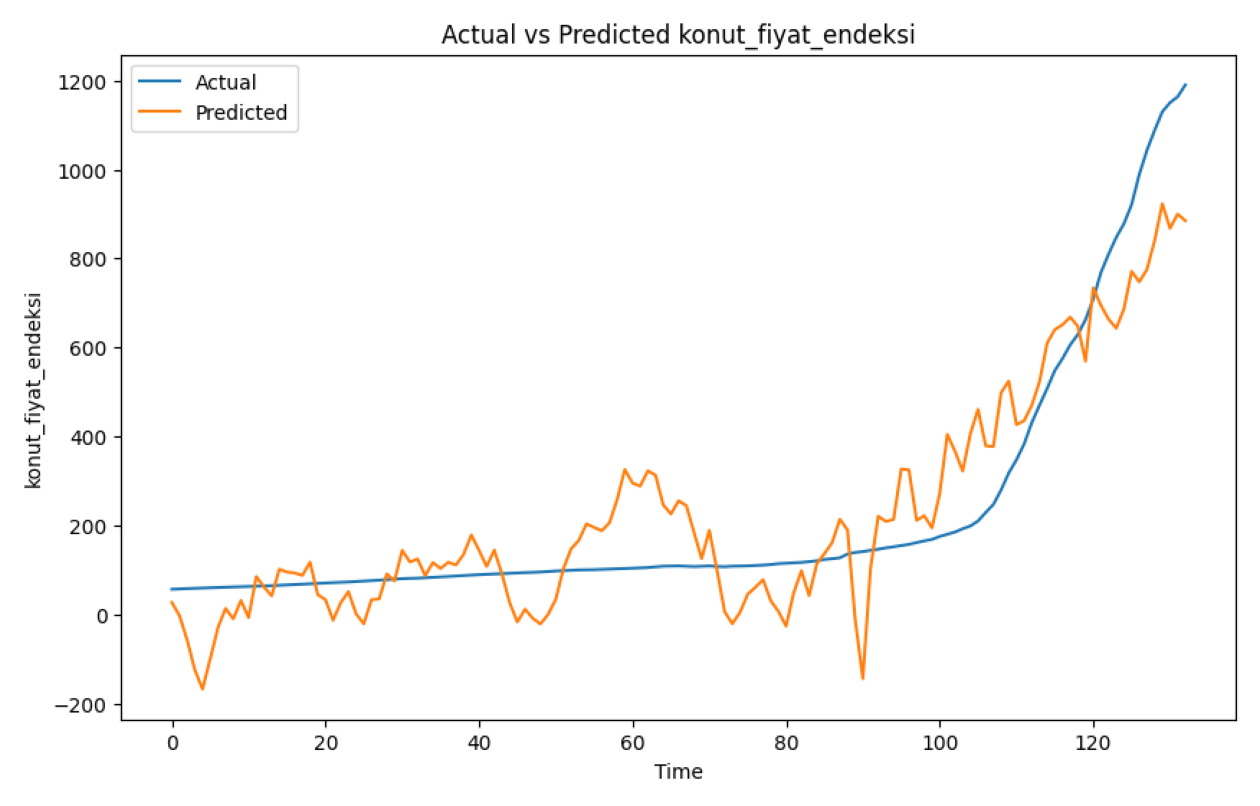

In [198]:
# Read the image
img = mpimg.imread("/content/fiyat_endeks.png")

# Create a larger figure
plt.figure(figsize=(16, 13))

# Display the image
plt.imshow(img)

# Turn off axis
plt.axis("off")

# Show the image
plt.show()

## Target: Unemployment Rate

R-squared: 0.958

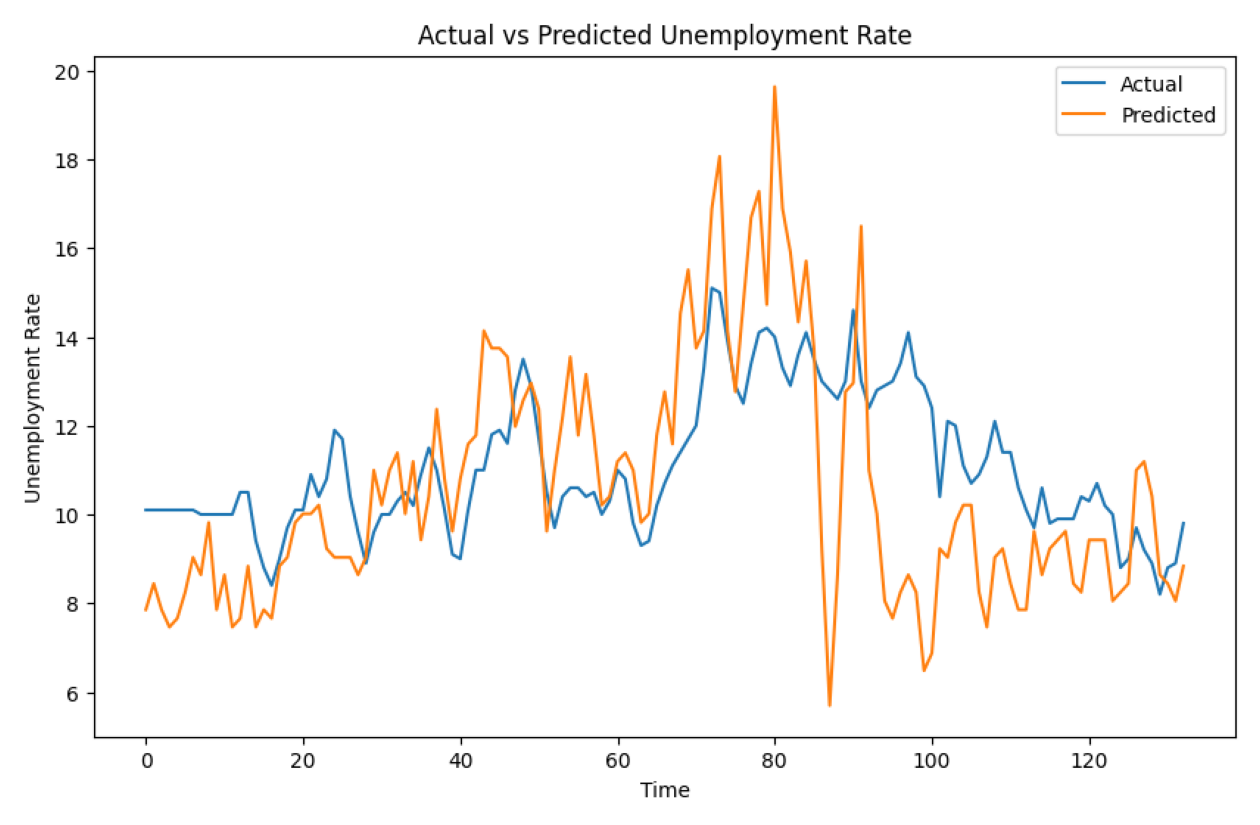

In [199]:
# Read the image
img = mpimg.imread("/content/unemployment.png")

# Create a larger figure
plt.figure(figsize=(16, 13))

# Display the image
plt.imshow(img)

# Turn off axis
plt.axis("off")

# Show the image
plt.show()